In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
%cd gdrive/MyDrive/Colab\ Notebooks/Object\ detection/object-detection-notebooks

/content/gdrive/MyDrive/Colab Notebooks/Object detection/object-detection-notebooks


In [3]:
import tensorflow as tf
print(tf.__version__)
tf.config.list_physical_devices()

2.5.0


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os

In [5]:
BASE_PATH = "dataset"
IMAGES_PATH = os.path.sep.join([BASE_PATH, "images"])
ANNOTS_PATH = os.path.sep.join([BASE_PATH, "airplanes.csv"])
rows = open(ANNOTS_PATH).read().strip().split("\n")
# initialize the list of data (images), our target output predictions
# (bounding box coordinates), along with the filenames of the
# individual images
data = []
targets = []
filenames = []

In [6]:
# loop over the rows
for row in rows:
    # break the row into the filename and bounding box coordinates
    (filename, startX, startY, endX, endY) = row.split(",")

    # derive the path to the input image, load the image (in OpenCV
    # format), and grab its dimensions
    imagePath = os.path.sep.join([IMAGES_PATH, filename])
    image = cv2.imread(imagePath)
    (h, w) = image.shape[:2]

    # scale the bounding box coordinates relative to the spatial
    # dimensions of the input image
    startX = float(startX) / w
    startY = float(startY) / h
    endX = float(endX) / w
    endY = float(endY) / h

    # load the image and preprocess it
    image = load_img(imagePath, target_size=(224, 224))
    image = img_to_array(image)

    # update our list of data, targets, and filenames
    data.append(image)
    targets.append((startX, startY, endX, endY))
    filenames.append(filename)

In [7]:
# convert the data and targets to NumPy arrays, scaling the input
# pixel intensities from the range [0, 255] to [0, 1]
data = np.array(data, dtype="float32") / 255.0
targets = np.array(targets, dtype="float32")

In [8]:
# partition the data into training and testing splits using 90% of
# the data for training and the remaining 10% for testing
split = train_test_split(data, targets, filenames, test_size=0.10, random_state=42)

# unpack the data split
(trainImages, testImages) = split[:2]
(trainTargets, testTargets) = split[2:4]
(trainFilenames, testFilenames) = split[4:]

In [9]:
# load the VGG16 network, ensuring the head FC layers are left off
vgg = VGG16(weights="imagenet", include_top=False)
vgg.trainable = False

58892288/58889256 [==============================] - 0s 0us/step


In [10]:
i = Input(shape=((224, 224, 3)))
x = vgg(i)
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dense(64, activation='relu')(x)
x = Dense(32, activation='relu')(x)
x = Dense(4, activation='sigmoid')(x)

model = Model(inputs=i, outputs=x, name='simple-regression')

model.compile(loss='mse', optimizer=Adam(learning_rate=1e-4))

H = model.fit(
trainImages, trainTargets,
validation_data=(testImages, testTargets),
batch_size=32,
epochs=25,
verbose=1)

Epoch 1/25
23/23 [==============================] - 42s 276ms/step - loss: 0.0683 - val_loss: 0.0025
Epoch 2/25
23/23 [==============================] - 3s 131ms/step - loss: 0.0021 - val_loss: 0.0017
Epoch 3/25
23/23 [==============================] - 3s 131ms/step - loss: 0.0015 - val_loss: 7.6759e-04
Epoch 4/25
23/23 [==============================] - 3s 131ms/step - loss: 0.0011 - val_loss: 6.8537e-04
Epoch 5/25
23/23 [==============================] - 3s 132ms/step - loss: 9.9013e-04 - val_loss: 6.1943e-04
Epoch 6/25
23/23 [==============================] - 3s 132ms/step - loss: 9.0151e-04 - val_loss: 5.7625e-04
Epoch 7/25
23/23 [==============================] - 3s 132ms/step - loss: 8.2809e-04 - val_loss: 5.5106e-04
Epoch 8/25
23/23 [==============================] - 3s 132ms/step - loss: 7.6204e-04 - val_loss: 5.2713e-04
Epoch 9/25
23/23 [==============================] - 3s 133ms/step - loss: 7.0429e-04 - val_loss: 5.1170e-04
Epoch 10/25
23/23 [==============================] 

In [11]:
model.save("localization.h5", save_format="h5")

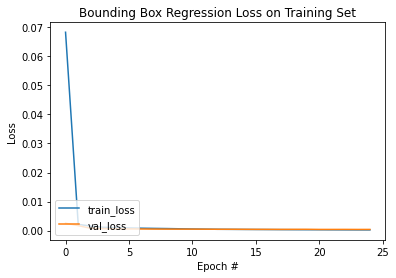

In [12]:
N = H.params['epochs']
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.title("Bounding Box Regression Loss on Training Set")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")

Source:

https://www.pyimagesearch.com/2020/10/05/object-detection-bounding-box-regression-with-keras-tensorflow-and-deep-learning/